In [1]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors 
from sklearn.manifold import TSNE
import selfies as sf
from DataProc import *

In [9]:
data_art = DataAnalyser('d2', 'artificial')
data_org = DataAnalyser('d2', 'klek_balanced')

art_df = data_art()
org_df = data_org()
org_df = org_df[org_df["Class"] == 1]
org_df = org_df.sample(n=500).drop(['Class', 'Ki'], axis=1)

art_df['Class'] = 'Artificial'
org_df['Class'] = 'Original'

combined_df = pd.concat([art_df, org_df], axis=0)
combined_df = combined_df.reset_index()
print(combined_df.head(), len(combined_df))

   index                                SMILES   
0      0             O=C/C=C/C=CN(CCCC)CCC1CC1  \
1      1      CCC1=CC=CC=C1CCCN(CCCC2)CC2CCCCC   
2      2       C=CC=C(CCCN(CCCC)C=CCCCC)C1C=C1   
3      3            CC=CN=C(CC)CCCCCCCCC1=C=C1   
4      4  FC=CC=C(CCCC(CCCC)CCCCCCCC)CCCCC1CC1   

                                                 fps       Class  
0  [0, 125, 188, 227, 296, 297, 340, 343, 361, 38...  Artificial  
1  [0, 296, 297, 340, 343, 345, 353, 361, 381, 43...  Artificial  
2  [0, 125, 137, 296, 337, 340, 343, 361, 381, 46...  Artificial  
3  [125, 296, 340, 343, 345, 346, 347, 465, 668, ...  Artificial  
4  [0, 125, 227, 296, 297, 340, 343, 345, 346, 34...  Artificial   1000


In [10]:
fp_list = []
for i, row in combined_df.iterrows():
    line = row['fps'].strip('[').strip(']').split(",")
    line = [int(x) for x in line]
    vec = np.zeros(4860, dtype='int')
    for fp in line:
        vec[fp] = 1
    fp_list.append(vec)

In [11]:
array = np.array(fp_list)
tsne = TSNE()
tsne_results = tsne.fit_transform(array)
tsne_dict = {"X": tsne_results[:,0], "Y": tsne_results[:,1]}
tsne_df = pd.DataFrame(tsne_dict)
print(tsne_df.head(), len(tsne_df))

           X          Y
0  -0.152617 -14.252079
1  10.588883 -14.387411
2   1.024137 -13.325205
3 -23.426908  17.027868
4 -60.809681  13.467959 1000


In [12]:
combined_df = combined_df.reset_index()

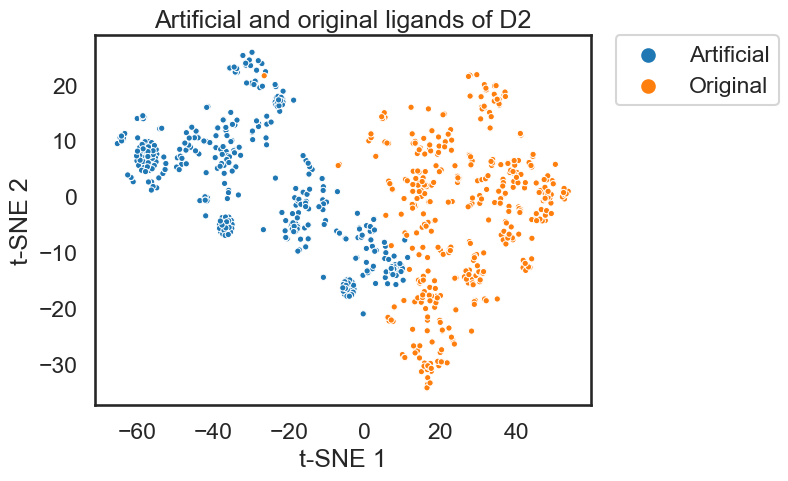

In [13]:
plot_TSNE(combined_df, title="Artificial and original ligands of D2", save_path=f"./artificial/d2-TSNE.png", save=False)

                                 SMILES   
0             O=C/C=C/C=CN(CCCC)CCC1CC1  \
1      CCC1=CC=CC=C1CCCN(CCCC2)CC2CCCCC   
2       C=CC=C(CCCN(CCCC)C=CCCCC)C1C=C1   
3            CC=CN=C(CC)CCCCCCCCC1=C=C1   
4  FC=CC=C(CCCC(CCCC)CCCCCCCC)CCCCC1CC1   

                                                 fps  Molecular weight   
0  [0, 125, 188, 227, 296, 297, 340, 343, 361, 38...           221.344  \
1  [0, 296, 297, 340, 343, 345, 353, 361, 381, 43...           315.545   
2  [0, 125, 137, 296, 337, 340, 343, 361, 381, 46...           287.491   
3  [125, 296, 340, 343, 345, 346, 347, 465, 668, ...           245.410   
4  [0, 125, 227, 296, 297, 340, 343, 345, 346, 34...           392.687   

      LogP  Number of HBD  Number of HBA  Number of heteroatoms   TPSA   
0   3.1574            0.0            2.0                    2.0  20.31  \
1   5.8640            0.0            1.0                    1.0   3.24   
2   5.8710            0.0            1.0                    1.0   3.24   


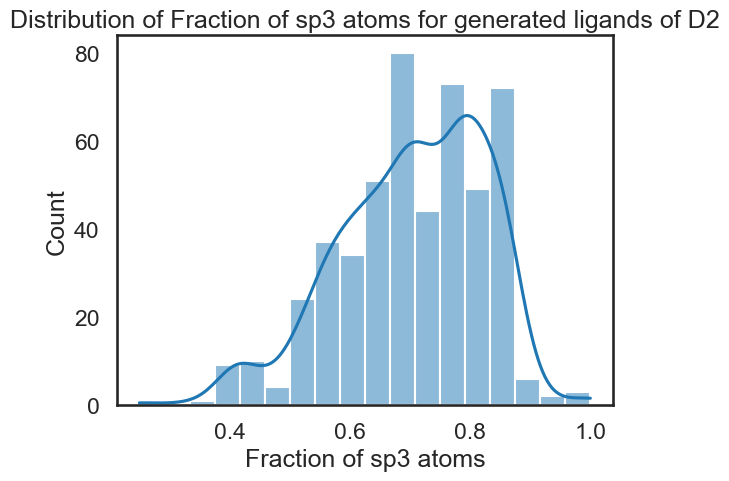

In [14]:
data = DataAnalyser('d2', 'artificial')
data.add_properties()
print(data.df.head())
data.plot_distribution("Fraction of sp3 atoms", save=False)

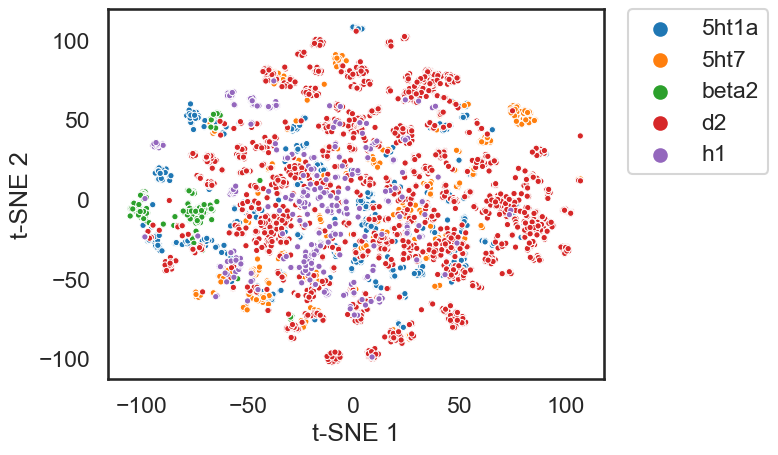

In [15]:
data = DataAnalyser('5ht1a', 'klek_balanced')
data.TSNE_all(title="", save_path = './t-SNE/Proteins_all_TSNE.png', save=False)

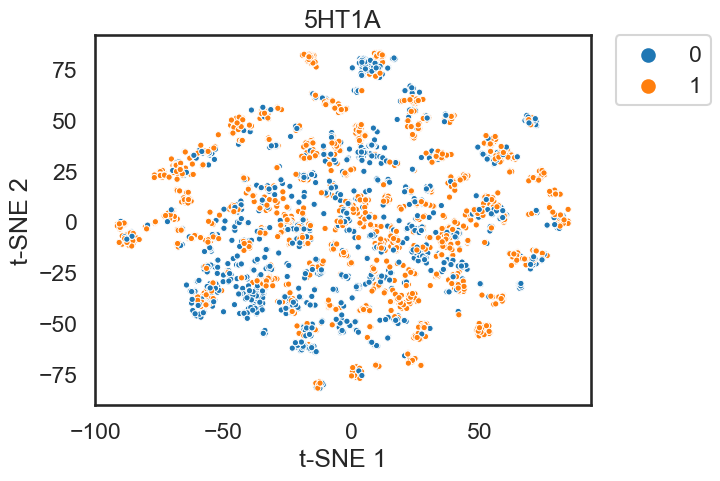

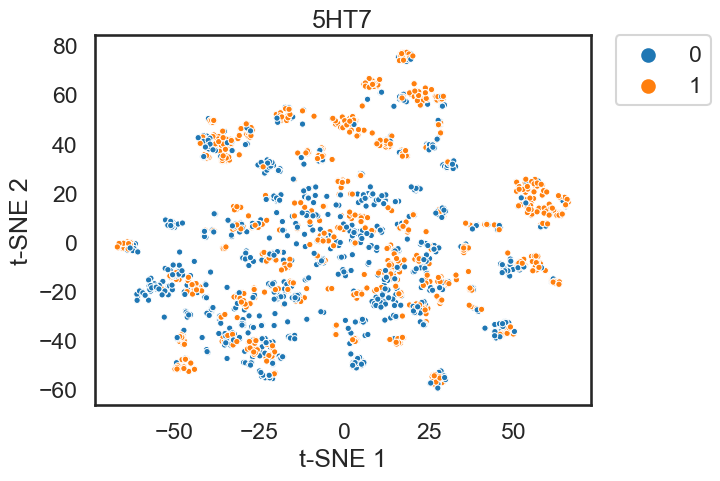

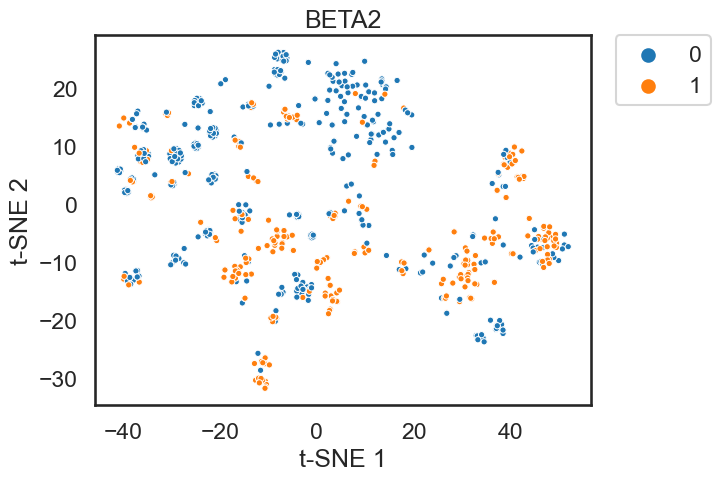

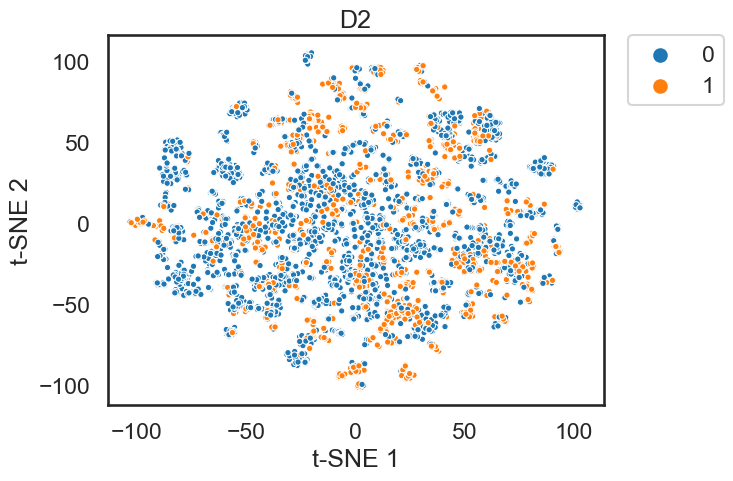

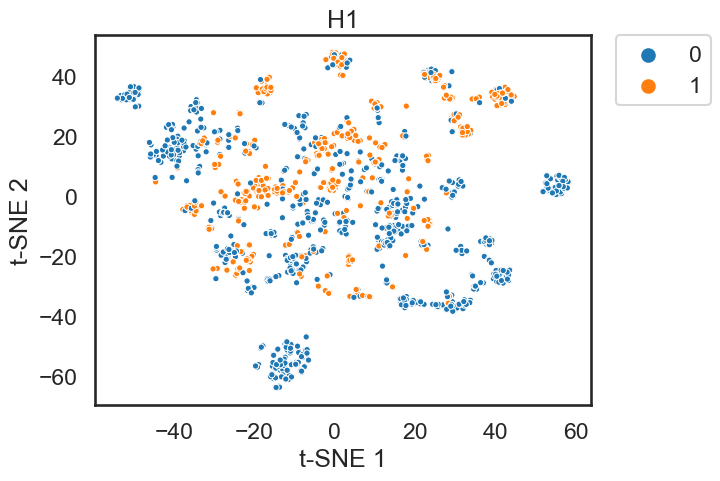

In [4]:
for protein in ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']:
    data = DataAnalyser(protein, 'klek_100nM')
    save_path = f"./fp_TSNE_100nM/{protein}_TSNE.png"
    plot_TSNE(data.df, title=f"{protein.upper()}",save_path=save_path, save=True)

In [2]:
def unpack_fps(fps_string):
    string_split = fps_string.strip("[").strip(']').split(',')
    split_list = [int(x) for x in string_split]
    return split_list

def fps_to_vec(fps_list):
    vec = np.zeros(4860)
    for indx in fps_list:
        vec[indx] = 1
    return vec.astype('int')
    
class FPMaker:
    def __init__(self, protein, dtype: ['klek_balanced', 'klek_100nM']):
        self.protein = protein
        self.dtype = dtype
        if dtype == 'klek_balanced':
            self.data_path = f"./klek_clean/{protein}_{dtype}.csv"
        elif dtype == 'klek_100nM':
            self.data_path = f"./klek_clean/{protein}_{dtype}.csv"
        else:
            print("Data not found")
        self.df = pd.read_csv(self.data_path, sep=',')
        self.df = pd.concat([self.df.drop(columns='fps'), self.df['fps'].apply(unpack_fps)], axis=1)
        self.df = pd.concat([self.df.drop(columns='fps'), self.df['fps'].apply(fps_to_vec)], axis=1)
        with open(f'./keys/KlekFP_keys.txt') as f:
            file = f.readlines()
            self.keys = pd.DataFrame({'KEYS':[f'KLEK_{x+1}' for x in range(4860)], 'SMARTS':[x.strip("\n") for x in file]})
    
    def unpack(self):
        new_array = np.vstack(self.df['fps'])
        new_df = pd.DataFrame(new_array)
        self.df = pd.concat([self.df, new_df], axis=1)
        
    def split_active_inactive(self):
        self.df_active = self.df[self.df['Class'] == 1]
        self.df_inactive = self.df[self.df['Class'] == 0]
    
    def count_keys(self, save=False):
        names = ['Full', 'Active', 'Inactive']
        df = [self.df, self.df_active, self.df_inactive]
        for name, df in zip(names, df):
            count_df = df.iloc[:,4:]
            count = pd.Series(count_df.sum(), name=f'{self.protein}_{name}')
            self.keys = pd.concat([self.keys, count], axis=1)  
        print(self.keys.head())
        if save:
            save_path = f"./fp_frequency_100nM/{self.protein}.csv"
            self.keys.to_csv(save_path, sep=',', header=True, index=False)
    
    def __call__(self):
        return self.df

In [17]:
for protein in ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']:
    data = FPMaker(protein, 'klek_100nM')
    data.unpack()
    df = data()
    df = df.drop(columns=['SMILES', 'Class', 'Ki', 'fps'])
    sums = df.sum(axis=1, numeric_only=True)
    mean = np.mean(sums)
    std = np.std(sums)
    print(f"The mean for {protein} is {mean}, with the SD of {std}")


The mean for 5ht1a is 60.61257142857143, with the SD of 20.292226849969232
The mean for 5ht7 is 57.07593655079312, with the SD of 21.53860597099623
The mean for beta2 is 60.24168797953964, with the SD of 21.135881206814556
The mean for d2 is 61.86155358898722, with the SD of 21.807373987290696
The mean for h1 is 58.56298048492017, with the SD of 23.510935118008696


In [10]:
for protein in ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']:
    data = FPMaker(protein, 'klek_100nM')
    data.unpack()
    data.split_active_inactive()
    data.count_keys(save=True)

     KEYS                                             SMARTS  5ht1a_Full  \
0  KLEK_1                              [!#1][CH]([!#1])[!#1]        2806   
1  KLEK_2                   [!#1][CH]([!#1])[CH]([!#1])[!#1]         338   
2  KLEK_3    [!#1][CH]([!#1])[CH]([!#1])C([CH3])([CH3])[CH3]           0   
3  KLEK_4       [!#1][CH]([!#1])[CH](C(=O)O[CH3])C(=O)O[CH3]           0   
4  KLEK_5  [!#1][CH]([!#1])[CH]1[CH2][CH]([CH]([!#1])[!#1...           0   

   5ht1a_Active  5ht1a_Inactive  
0          1661            1145  
1           212             126  
2             0               0  
3             0               0  
4             0               0  
     KEYS                                             SMARTS  5ht7_Full  \
0  KLEK_1                              [!#1][CH]([!#1])[!#1]       1298   
1  KLEK_2                   [!#1][CH]([!#1])[CH]([!#1])[!#1]        117   
2  KLEK_3    [!#1][CH]([!#1])[CH]([!#1])C([CH3])([CH3])[CH3]          0   
3  KLEK_4       [!#1][CH]([!#1])[CH](C(

In [11]:
class FPCombiner:
    def __init__(self):
        self.paths = []
        self.proteins = ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']
        for i, file in enumerate(os.scandir(f"./fp_frequency_100nM")):
            if i == 0:
                self.df = pd.read_csv(file.path, sep=',')
            else:
                new_df = pd.read_csv(file.path, sep=',')
                self.df = self.df.merge(new_df, on=['KEYS', 'SMARTS'])
    
    def write(self, kind):
        save_df = self.df.loc[:,("KEYS")]
        selection = tuple(f"{protein}_{kind}" for protein in self.proteins)
        save_df = pd.concat([save_df, self.df.loc[:,selection]], axis=1)
        save_df = pd.concat([save_df, self.df.loc[:,"SMARTS"]], axis=1)
        names = {f'5ht1a_{kind}':'5ht1a'}
        save_df.columns = ['KEYS', '5ht1a', '5ht7','beta2', 'd2', 'h1', 'SMARTS']
        print(save_df.head())
        save_path = f'./counts_{kind.lower()}.csv'
        save_df.to_csv(save_path, sep=',', header='True', index=False)

            

In [12]:
FPComb = FPCombiner()
FPComb.write('Full')
FPComb.write('Active')
FPComb.write('Inactive')

     KEYS  5ht1a  5ht7  beta2    d2   h1  \
0  KLEK_1   2806  1298    705  5448  998   
1  KLEK_2    338   117     71   760   96   
2  KLEK_3      0     0      0     0    0   
3  KLEK_4      0     0      0     0    0   
4  KLEK_5      0     0      0     0    0   

                                              SMARTS  
0                              [!#1][CH]([!#1])[!#1]  
1                   [!#1][CH]([!#1])[CH]([!#1])[!#1]  
2    [!#1][CH]([!#1])[CH]([!#1])C([CH3])([CH3])[CH3]  
3       [!#1][CH]([!#1])[CH](C(=O)O[CH3])C(=O)O[CH3]  
4  [!#1][CH]([!#1])[CH]1[CH2][CH]([CH]([!#1])[!#1...  
     KEYS  5ht1a  5ht7  beta2    d2   h1  \
0  KLEK_1   1661   720    320  1812  450   
1  KLEK_2    212    42     46   261   41   
2  KLEK_3      0     0      0     0    0   
3  KLEK_4      0     0      0     0    0   
4  KLEK_5      0     0      0     0    0   

                                              SMARTS  
0                              [!#1][CH]([!#1])[!#1]  
1                   [!#1][CH](

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from DataProc import FPImbalancedAnalyser 

In [8]:
for protein in ['5ht1a', '5ht7', 'beta2', 'd2', 'h1']:
    data = pd.read_csv(f"./klek_clean/{protein}_klek_100nM.csv", sep=',')
    print(f"The full size of dataset: {len(data)} /n", f"Size active: {len(data[data['Class'] == 1])} /n", f"Size inactive: {len(data[data['Class'] == 0])}")

The full size of dataset: 5250 /n Size active: 3043 /n Size inactive: 2207
The full size of dataset: 2963 /n Size active: 1526 /n Size inactive: 1437
The full size of dataset: 782 /n Size active: 331 /n Size inactive: 451
The full size of dataset: 10170 /n Size active: 3713 /n Size inactive: 6457
The full size of dataset: 1691 /n Size active: 641 /n Size inactive: 1050


     KEYS  5ht1a_active  5ht7_active  beta2_active  d2_active  h1_active  \
0  KLEK_1          1661          720           320       1812        450   
1  KLEK_2           212           42            46        261         41   
2  KLEK_3             0            0             0          0          0   
3  KLEK_4             0            0             0          0          0   
4  KLEK_5             0            0             0          0          0   

                                              SMARTS  5ht1a_percentage_active  \
0                              [!#1][CH]([!#1])[!#1]                54.584292   
1                   [!#1][CH]([!#1])[CH]([!#1])[!#1]                 6.966809   
2    [!#1][CH]([!#1])[CH]([!#1])C([CH3])([CH3])[CH3]                 0.000000   
3       [!#1][CH]([!#1])[CH](C(=O)O[CH3])C(=O)O[CH3]                 0.000000   
4  [!#1][CH]([!#1])[CH]1[CH2][CH]([CH]([!#1])[!#1...                 0.000000   

   5ht7_percentage_active  beta2_percentage_active  ... 

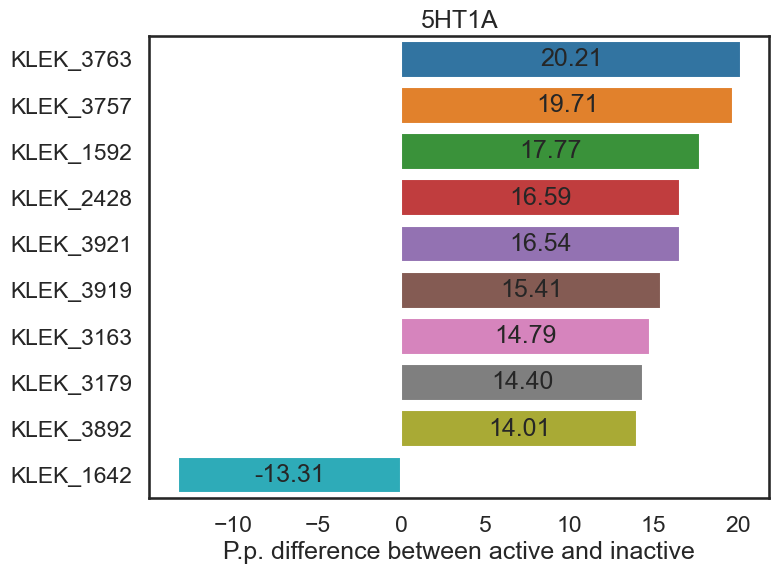

           KEYS                                  SMARTS  5ht7_percentage  \
3681  KLEK_3682                              CCc1ccccc1        15.619268   
437    KLEK_438  [!#1][CH2][CH2]N([CH2][!#1])[CH2][!#1]        14.995608   
619    KLEK_620       [!#1][CH2]N([CH2][!#1])[CH2][!#1]        14.852371   
3756  KLEK_3757                               CCN(CC)CC        14.743883   
3740  KLEK_3741                                CCCN(C)C        14.442952   

      5ht7_percentage_abs  
3681            15.619268  
437             14.995608  
619             14.852371  
3756            14.743883  
3740            14.442952  


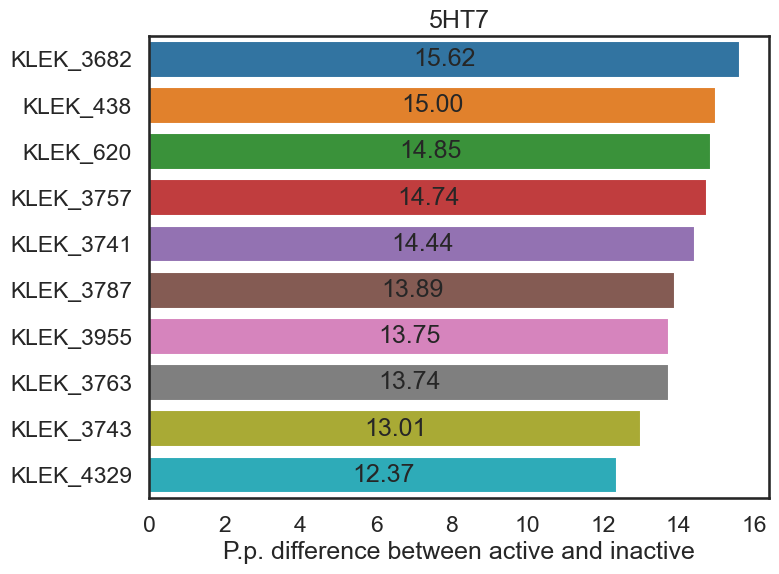

           KEYS                                  SMARTS  beta2_percentage  \
646    KLEK_647                        [!#1][CH2]O[!#1]         34.519463   
3743  KLEK_3744                                    CCCO         33.394069   
1645  KLEK_1646  [!#1]c1[cH][cH]c([!#1])c([!#1])c1[!#1]         27.850162   
2546  KLEK_2547                             [!#1]O[!#1]         27.795902   
3407  KLEK_3408                                  CC(C)O         27.010805   

      beta2_percentage_abs  
646              34.519463  
3743             33.394069  
1645             27.850162  
2546             27.795902  
3407             27.010805  


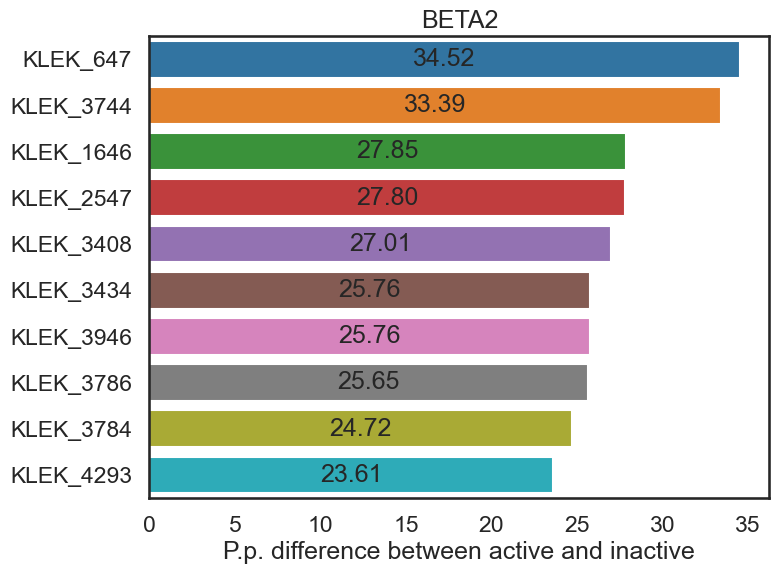

           KEYS                          SMARTS  d2_percentage  \
3762  KLEK_3763                      CCN(CC)CCN      18.359938   
343    KLEK_344       [!#1][CH2][CH2][CH2][!#1]      17.251860   
3756  KLEK_3757                       CCN(CC)CC      16.115419   
345    KLEK_346  [!#1][CH2][CH2][CH2][CH2][!#1]      15.830403   
3918  KLEK_3919             CN1CCN(CC1)c2ccccc2      15.778278   

      d2_percentage_abs  
3762          18.359938  
343           17.251860  
3756          16.115419  
345           15.830403  
3918          15.778278  


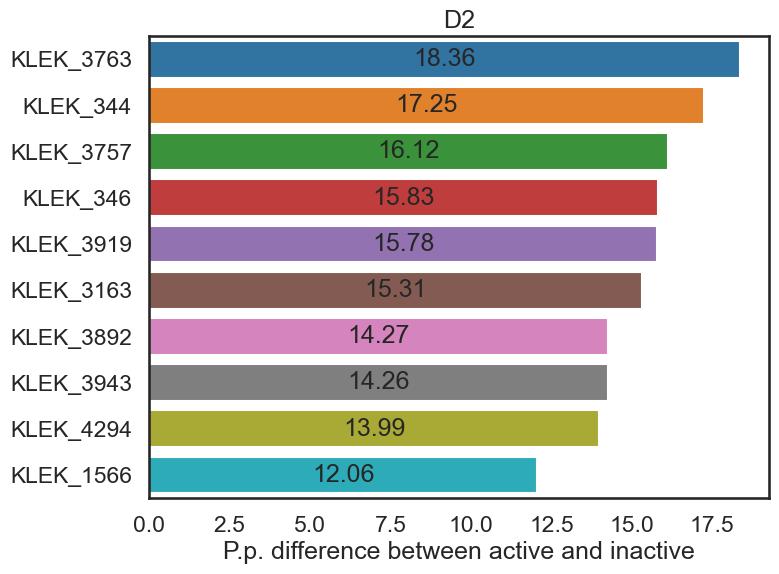

           KEYS                          SMARTS  h1_percentage  \
1565  KLEK_1566  [!#1]c1[cH][cH][cH][cH]c1[!#1]      35.159052   
343    KLEK_344       [!#1][CH2][CH2][CH2][!#1]     -31.953347   
2263  KLEK_2264              [!#1]N([!#1])[CH3]      26.638734   
607    KLEK_608         [!#1][CH2]N([!#1])[CH3]      24.791175   
2258  KLEK_2259                         [!#1]Cl      22.802912   

      h1_percentage_abs  
1565          35.159052  
343           31.953347  
2263          26.638734  
607           24.791175  
2258          22.802912  


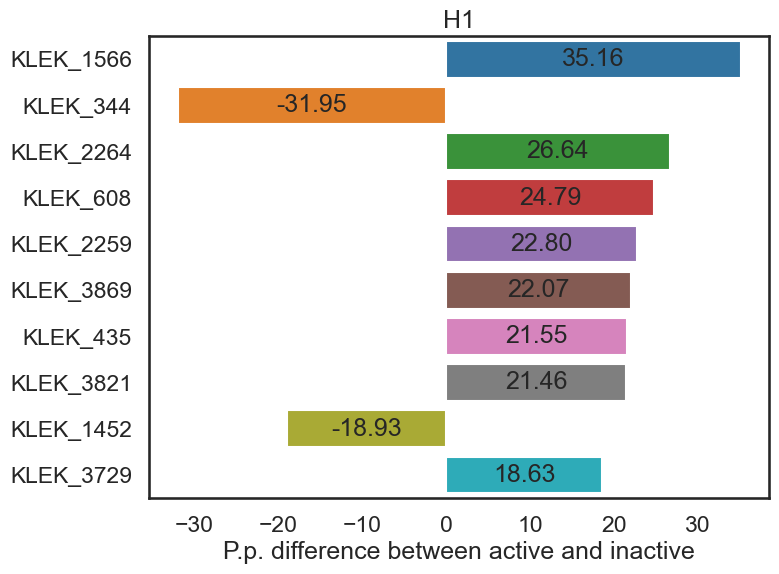

In [4]:
FP = FPImbalancedAnalyser()
FP.calcualte_percentage_difference()
FP.save_frequency()
FP.plot_abs_frequencies(save=True)

DO PUBLIKACJI

In [2]:
proteins = ['5ht1a','5ht7','beta2','d2','h1']
properties = ['Number of HBA', 'Number of HBD', 'LogP', 'Molecular weight']
for protein in proteins:
    data = DataAnalyser(protein, 'klek_100nM')
    data.add_properties()
    for prop in properties:
        data.plot_distribution(prop, save=True, av=True)
        data.plot_distribution_no_legend(prop, save=True, av=True)

<Figure size 640x480 with 0 Axes>

In [3]:
proteins = ['5ht1a','5ht7','beta2','d2','h1']
#proteins = ['5ht1a']
properties = ['Number of HBA', 'Number of HBD', 'LogP', 'Molecular weight']
values = [[0,10], [0,5], [0,5], [0,500]]
counts = []
for protein in proteins:
    data = DataAnalyser(protein, 'klek_100nM')
    data.add_properties()
    active = data.df[data.df['Class'] == 1]
    inactive = data.df[data.df['Class'] == 0]
    size_active = len(active)
    size_inactive = len(inactive)
    for prop, value in zip(properties, values):
        count_active = len(active[np.logical_and(active[prop] < value[1], active[prop] > value[0])])
        count_inactive = len(inactive[np.logical_and(inactive[prop] < value[1], inactive[prop] > value[0])])
        counts.append([prop, count_active, size_active, 'active', protein])
        counts.append([prop, count_inactive, size_inactive, 'inactive', protein])
print(counts)

[['Number of HBA', 3033, 3043, 'active', '5ht1a'], ['Number of HBA', 2193, 2207, 'inactive', '5ht1a'], ['Number of HBD', 2002, 3043, 'active', '5ht1a'], ['Number of HBD', 1471, 2207, 'inactive', '5ht1a'], ['LogP', 2519, 3043, 'active', '5ht1a'], ['LogP', 1795, 2207, 'inactive', '5ht1a'], ['Molecular weight', 2755, 3043, 'active', '5ht1a'], ['Molecular weight', 2026, 2207, 'inactive', '5ht1a'], ['Number of HBA', 1522, 1526, 'active', '5ht7'], ['Number of HBA', 1429, 1437, 'inactive', '5ht7'], ['Number of HBD', 1011, 1526, 'active', '5ht7'], ['Number of HBD', 903, 1437, 'inactive', '5ht7'], ['LogP', 1257, 1526, 'active', '5ht7'], ['LogP', 1159, 1437, 'inactive', '5ht7'], ['Molecular weight', 1372, 1526, 'active', '5ht7'], ['Molecular weight', 1332, 1437, 'inactive', '5ht7'], ['Number of HBA', 322, 331, 'active', 'beta2'], ['Number of HBA', 444, 451, 'inactive', 'beta2'], ['Number of HBD', 268, 331, 'active', 'beta2'], ['Number of HBD', 353, 451, 'inactive', 'beta2'], ['LogP', 296, 331, '

In [4]:
compiled_data = pd.DataFrame(counts, columns=['Parameter', 'No. fulfilling', 'Total number', 'Class', 'Protein'])

In [5]:
compiled_data.to_csv('./Rules_of_Lipinski_MW_0-500.csv', sep=',', header=True, index=False)

In [8]:
sns.set_style('white')
sns.set_context('talk')
proteins = ['5ht1a','5ht7','beta2','d2','h1']
for protein in proteins:
    data = pd.read_csv(f"./Rules_of_Lipinski_MW_0-500.csv", sep=',')
    protein_data = data[data['Protein'] == protein]
    protein_data['%'] = protein_data['No. fulfilling'] / protein_data['Total number'] * 100
    ax = sns.barplot(data=protein_data, x='Parameter', y='%', hue='Class', hue_order=['inactive', 'active'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("")
    plt.ylabel("% fulfulling")
    plt.title(f"Satisfaction of Lipinski's rules by {protein.upper()} ligands")
    ax.set_ylim(0,100)
    ax.set(xlabel=None)
    #ax.bar_label(ax.containers[0])
    #ax.bar_label(ax.containers[1])
    plt.savefig(f'./Lipinski_rules/{protein}_MW_0-500.png', dpi=300, bbox_inches='tight')
    plt.clf()

C:\Users\matit\AppData\Local\Temp\ipykernel_3084\3422268297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_data['%'] = protein_data['No. fulfilling'] / protein_data['Total number'] * 100
C:\Users\matit\AppData\Local\Temp\ipykernel_3084\3422268297.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_data['%'] = protein_data['No. fulfilling'] / protein_data['Total number'] * 100
C:\Users\matit\AppData\Local\Temp\ipykernel_3084\3422268297.py:7: SettingWithCopyWarning: 
A value is trying to 

<Figure size 640x480 with 0 Axes>